In [1]:
!pip install aquirdturtle_collapsible_headings
!pip install 'python-lsp-server[all]'
!pip install jupyterlab-spellchecker
!pip install jupyterlab-code-formatter

  Using cached jupyterlab-3.6.8-py3-none-any.whl.metadata (12 kB)
Using cached jupyterlab-3.6.8-py3-none-any.whl (8.9 MB)
  Attempting uninstall: jupyterlab
    Found existing installation: jupyterlab 4.4.1
    Uninstalling jupyterlab-4.4.1:
      Successfully uninstalled jupyterlab-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-spellchecker 0.8.4 requires jupyterlab<5,>=4, but you have jupyterlab 3.6.8 which is incompatible.
  Using cached jupyterlab-4.4.1-py3-none-any.whl.metadata (16 kB)
Using cached jupyterlab-4.4.1-py3-none-any.whl (12.3 MB)
  Attempting uninstall: jupyterlab
    Found existing installation: jupyterlab 3.6.8
    Uninstalling jupyterlab-3.6.8:
      Successfully uninstalled jupyterlab-3.6.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sourc

In [2]:
!pip install numpy pandas scikit-learn shap scipy kagglehub

In [6]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans

class RSKC:
    """
    Implementação do algoritmo Robust Sparse K-means baseado no artigo Kondo et al. (2016).
    """
    def __init__(self, n_clusters=3, alpha=0.1, L1=None, n_init=10, max_iter=300, tol=1e-4, random_state=None):
        """
        Inicializa o RobustSparseKMeans.

        Args:
            n_clusters (int): O número de clusters.
            alpha (float): A proporção de observações a serem aparadas (entre 0 e 0.5).
            L1 (float or None): O limite L1 para os pesos das características. Use None para K-means aparado não esparso.
            n_init (int): O número de vezes que o algoritmo K-means será executado com diferentes sementes de centróides.
            max_iter (int): O número máximo de iterações do algoritmo RSK-means para uma única execução.
            tol (float): A tolerância para a convergência.
            random_state (int or None): A semente para o gerador de números aleatórios para inicialização.
        """
        if not 0 <= alpha < 0.5:
            raise ValueError("alpha deve estar entre 0 (inclusive) e 0.5 (exclusivo)")
        if L1 is not None and L1 <= 1:
             # L1 > 1 de acordo com o artigo para induzir esparsidade
             # Para L1=None, tratamos como K-means aparado não esparso
             if L1 <= 1:
                 print("Aviso: L1 <= 1 pode não induzir esparsidade. Considere L1 > 1 ou None para não esparso.")
                 #raise ValueError("L1 deve ser maior que 1 para induzir esparsidade ou None para K-means aparado não esparso.")

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.L1 = L1
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.labels_ = None
        self.cluster_centers_ = None
        self.weights_ = None
        self.trimmed_indices_ = None

    def _initialize_centers(self, X):
        """
        Inicializa os centros do cluster usando K-means++.
        """
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=10, random_state=self.random_state)
        kmeans.fit(X)
        return kmeans.cluster_centers_

    def _assign_clusters_weighted(self, X, centers, weights):
        """
        Atribui pontos a clusters usando distâncias quadradas euclidianas ponderadas.
        """
        # Expande pesos para ter a mesma forma de X para multiplicação elemento a elemento
        weights_reshaped = weights.reshape(1, -1)
        weighted_X = X * np.sqrt(weights_reshaped)
        weighted_centers = centers * np.sqrt(weights_reshaped)

        distances = euclidean_distances(weighted_X, weighted_centers, squared=True)
        return np.argmin(distances, axis=1)

    def _assign_clusters_unweighted(self, X, centers):
         """
         Atribui pontos a clusters usando distâncias quadradas euclidianas não ponderadas.
         """
         distances = euclidean_distances(X, centers, squared=True)
         return np.argmin(distances, axis=1)


    def _update_centers_trimmed(self, X, labels, alpha, weights):
        """
        Atualiza os centros do cluster aparando a proporção alpha das observações.
        Usa distâncias ponderadas para identificar outliers para aparamento.
        """
        new_centers = np.zeros((self.n_clusters, X.shape[1]))
        trimmed_indices = []
        weights_reshaped = weights.reshape(1, -1)

        for k in range(self.n_clusters):
            cluster_points_indices = np.where(labels == k)[0]
            if len(cluster_points_indices) == 0:
                continue

            cluster_points = X[cluster_points_indices]
            weighted_cluster_points = cluster_points * np.sqrt(weights_reshaped)
            weighted_center = np.mean(weighted_cluster_points, axis=0)
            # Recalcular distâncias ponderadas para os pontos do cluster em relação ao seu centro ponderado
            distances = np.sum((weighted_cluster_points - weighted_center)**2, axis=1)

            num_to_trim = int(alpha * len(cluster_points_indices))
            if num_to_trim > 0:
                # Identificar os índices locais dos pontos a serem aparados no cluster
                local_trimmed_indices = np.argsort(distances)[-num_to_trim:]
                # Mapear de volta para os índices originais do dataset
                global_trimmed_indices = cluster_points_indices[local_trimmed_indices]
                trimmed_indices.extend(global_trimmed_indices)

                # Calcular o novo centro excluindo os pontos aparados
                remaining_indices = np.setdiff1d(cluster_points_indices, global_trimmed_indices)
                if len(remaining_indices) > 0:
                    new_centers[k] = np.mean(X[remaining_indices], axis=0)
                else:
                    # Se todos os pontos foram aparados (caso extremo), manter o centro anterior ou reinicializar?
                    # Para simplificar, vamos definir como zero ou podemos pensar em uma estratégia melhor.
                    new_centers[k] = np.zeros(X.shape[1]) # Ou manter o centro antigo: centers[k]

            else:
                # Nenhum ponto para aparar, calcular o centro normalmente
                new_centers[k] = np.mean(cluster_points, axis=0)

        return new_centers, trimmed_indices


    def _update_weights(self, X, labels, trimmed_indices):
        """
        Atualiza os pesos das características com base na maximização da dissimilaridade
        entre clusters, excluindo pontos aparados, com limite L1.
        """
        n_features = X.shape[1]
        B_j = np.zeros(n_features)
        untouched_X = np.delete(X, trimmed_indices, axis=0)
        untouched_labels = np.delete(labels, trimmed_indices)

        # Calcular B_j sem os pontos aparados
        for j in range(n_features):
            total_sq_dist_j = np.sum(np.diff(untouched_X[:, j])**2) # Simplificado, não a soma total par a par
            within_cluster_sq_dist_j = 0
            for k in range(self.n_clusters):
                cluster_points_j = untouched_X[untouched_labels == k, j]
                if len(cluster_points_j) > 0:
                    # Soma dos quadrados das diferenças dentro do cluster para a feature j
                    # Equivalente a sum((x_i - mean)^2) para i no cluster k, feature j
                    within_cluster_sq_dist_j += np.sum((cluster_points_j - np.mean(cluster_points_j))**2)

            B_j[j] = total_sq_dist_j - within_cluster_sq_dist_j # Esta não é a fórmula exata do artigo, é uma aproximação para a dissimilaridade

        # De acordo com o artigo[cite: 45], há uma expressão de forma fechada para w.
        # A lógica envolve projetar B_j em uma esfera L2 e depois encolher em direção a zero
        # para impor o limite L1 (uma variação do soft thresholding).

        # Implementação aproximada da atualização de peso baseada na ideia do artigo:
        # Normalize B_j e aplique soft thresholding para impor esparsidade L1.
        # O artigo menciona maximizar w^T * B(C) sujeito a ||w||_2 <= 1 e ||w||_1 <= l.
        # Uma forma de resolver isso é via dualidade ou um algoritmo iterativo.
        # Uma abordagem comum em problemas esparsos com penalidade L1 é usar soft thresholding.

        # Normalizar B_j para que ||B_j||_2 <= 1 (idealmente, mas vamos usar normalização simples por enquanto)
        B_j_norm = np.linalg.norm(B_j)
        if B_j_norm > 0:
            v = B_j / B_j_norm
        else:
            v = B_j # ou retornar pesos uniformes pequenos?

        # Aplicar soft thresholding para impor o limite L1 (l no artigo, self.L1 aqui)
        # A fórmula exata de soft thresholding para este problema pode ser complexa.
        # Uma aproximação comum para w_j é max(0, |v_j| - lambda) * sign(v_j)
        # onde lambda está relacionado ao limite L1.

        # O artigo [cite: 45] se refere a Witten and Tibshirani (2010) para a forma fechada.
        # A forma fechada para os pesos em Sparse K-means (sem robustez) envolve B_j.
        # Para RSK-means, B_j é calculado nos dados não aparados.

        # Vamos implementar uma versão simplificada da atualização de peso:
        # Calcular B_j de forma mais alinhada com o artigo (dissimilaridade entre clusters)
        # B_j(C) = sum_{i,i'} d_{i,i',j} / n - sum_k (1/n_k * sum_{i,i' in C_k} d_{i,i',j}) [cite: 42]
        # Para squared Euclidean distance: d_{i,i',j} = (x_{i,j} - x_{i',j})^2
        # sum_{i,i'} (x_{i,j} - x_{i',j})^2 = 2n * sum_i (x_{i,j} - mean(x_j))^2 = 2n * Var(x_j) * (n-1)/n * n = 2n(n-1)Var(x_j)
        # sum_{i,i' in C_k} (x_{i,j} - x_{i',j})^2 = 2n_k * sum_{i in C_k} (x_{i,j} - mean(x_k,j))^2 = 2n_k(n_k-1)Var(x_k,j)
        # B_j(C) = 2(n-1)Var(x_j) - sum_k (1/n_k * 2n_k(n_k-1)Var(x_k,j)) = 2(n-1)Var(x_j) - 2 sum_k (n_k-1)Var(x_k,j)
        # Esta é uma forma mais precisa de calcular B_j. Precisamos dos dados *não aparados*.

        n_untouched = untouched_X.shape[0]
        if n_untouched == 0:
             return np.ones(n_features) / n_features # Evitar divisão por zero ou retornar pesos pequenos

        B_j_accurate = np.zeros(n_features)
        for j in range(n_features):
             # Variância total da feature j nos dados não aparados
             total_var_j = np.var(untouched_X[:, j]) * (n_untouched - 1) # Sum of squares from mean

             within_cluster_var_j = 0
             for k in range(self.n_clusters):
                 cluster_points_j = untouched_X[untouched_labels == k, j]
                 if len(cluster_points_j) > 1:
                     within_cluster_var_j += np.var(cluster_points_j) * (len(cluster_points_j) - 1)

             # Simplificação de B_j, focando na diferença de variância entre total e dentro dos clusters
             # O artigo usa B_j(C) que é relacionado à variância entre clusters
             # Uma proxy para B_j é a soma dos quadrados entre clusters para a feature j
             # que é n * Variância entre clusters.
             # Em vez disso, vamos usar uma métrica que reflete quão separadas as médias dos clusters estão para cada característica, ponderada pela variância dentro do cluster.
             # Isso não é diretamente do artigo, mas reflete a ideia de pesos maiores para features discriminativas.

             # Abordagem do artigo: B_j(C) no final da página 4. Maximize sum(w_j * B_j(C)) subject to L1 and L2 constraints.
             # B_j(C) = sum_{i=1}^n sum_{i'=1}^n d_{i,i',j} - sum_{k=1}^K (1/n_k) sum_{i,i' in C_k} d_{i,i',j} [cite: 45]
             # Para squared Euclidean distance, d_{i,i',j} = (x_{i,j} - x_{i',j})^2
             # sum_{i,i'} (x_{i,j} - x_{i',j})^2 = 2n * SS_total_j onde SS_total_j is sum of squares from mean for feature j over all n points.
             # sum_{i,i' in C_k} (x_{i,j} - x_{i',j})^2 = 2n_k * SS_within_k_j
             # B_j(C) = 2n * SS_total_j - sum_k (1/n_k) * 2n_k * SS_within_k_j = 2n * SS_total_j - 2 * sum_k SS_within_k_j
             # Onde SS_total_j = sum_{i=1}^n (x_{i,j} - mean(x_j))^2 e SS_within_k_j = sum_{i in C_k} (x_{i,j} - mean(x_k,j))^2

             # Vamos calcular B_j usando os dados NÃO aparados
             mean_j_untouched = np.mean(untouched_X[:, j])
             SS_total_j_untouched = np.sum((untouched_X[:, j] - mean_j_untouched)**2)

             SS_within_k_j_untouched = 0
             for k in range(self.n_clusters):
                 cluster_points_j_untouched = untouched_X[untouched_labels == k, j]
                 if len(cluster_points_j_untouched) > 0:
                     SS_within_k_j_untouched += np.sum((cluster_points_j_untouched - np.mean(cluster_points_j_untouched))**2)

             B_j_accurate[j] = 2 * n_untouched * SS_total_j_untouched - 2 * SS_within_k_j_untouched

        # Agora aplicamos a forma fechada para w_j que maximiza sum(w_j * B_j_accurate[j]) sujeito a ||w||_2 <= 1 e ||w||_1 <= self.L1
        # Esta forma fechada é (Soft Thresholding): w_j = sign(B_j_accurate[j]) * max(0, abs(B_j_accurate[j]) - lambda) / ||max(0, abs(B_j_accurate) - lambda)||_2
        # Onde lambda é escolhido tal que ||w||_1 = self.L1

        # Resolver para lambda tal que a norma L1 é self.L1. Isso geralmente requer busca.
        # Para simplificar, podemos usar uma busca bisseção ou iterar.
        # Uma abordagem mais simples (mas menos precisa) é normalizar B_j_accurate e aplicar soft thresholding.

        # Normalizar B_j_accurate e aplicar soft thresholding:
        # Encontre a constante de normalização para a penalidade L2 (||w||_2 <= 1)
        B_j_accurate_norm_l2 = np.linalg.norm(B_j_accurate)
        if B_j_accurate_norm_l2 == 0:
             return np.ones(n_features) / n_features # Evitar divisão por zero

        v = B_j_accurate / B_j_accurate_norm_l2

        # Aplicar soft thresholding para o limite L1.
        # Precisamos encontrar lambda tal que sum(max(0, |v_j| - lambda)) = self.L1
        # Isto não é diretamente self.L1, a relação entre lambda e L1 é mais complexa.

        # Vamos usar uma busca iterativa ou uma aproximação.
        # Uma busca bisseção por lambda é comum para satisfazer a restrição L1.
        # Ou, uma forma mais simples: w_j = sign(B_j_accurate[j]) * max(0, abs(B_j_accurate[j]) - lambda) e depois normalizar para ||w||_2=1 e escalar para L1?

        # De acordo com o artigo "A Framework for Feature Selection in Clustering" (Witten & Tibshirani, 2010),
        # a solução para maximizar w^T * d subject to ||w||_2^2 <= 1, sum(w_j) <= l, w_j >= 0
        # onde d_j = B_j(C). A solução é dada por w_j = (d_j - gamma)_+ / ||(d - gamma)_+||_2
        # onde (x)_+ = max(0, x), e gamma é escolhido tal que sum((d_j - gamma)_+) = l * ||(d - gamma)_+||_2
        # No nosso caso, d_j = B_j_accurate[j].

        d = B_j_accurate
        if self.L1 is None:
             # K-means aparado não esparso: pesos uniformes
             weights = np.ones(n_features) / n_features
        else:
             # Implementar a busca por gamma (lambda no artigo de Witten & Tibshirani).
             # Precisamos encontrar gamma tal que sum(max(0, d - gamma)) = self.L1 * sqrt(sum(max(0, d - gamma)^2)).
             # Seja g(gamma) = sum(max(0, d - gamma)) - self.L1 * sqrt(sum(max(0, d - gamma)^2)). Encontre gamma tal que g(gamma)=0.
             # A função g(gamma) é decrescente em gamma. Podemos usar busca bisseção.

             if np.all(d <= 0): # Evitar problemas se todos B_j forem não positivos
                  weights = np.ones(n_features) / n_features
             else:
                 # Busca bisseção para gamma
                 gamma_min = np.max(d) # ensures max(0, d-gamma) has some non-zero elements
                 gamma_max = np.min(d) - np.sum(np.abs(d)) # ensures max(0, d-gamma) is likely all zero

                 # Ajustar limites para garantir que haja valores positivos após subtrair gamma
                 d_sorted = np.sort(d)[::-1] # Decrescente
                 # gamma_min: pick a value smaller than the largest d
                 gamma_min = d_sorted[0] - 1e-9 if d_sorted[0] > 0 else 1e-9
                 # gamma_max: pick a value larger than the smallest d, such that some values are zeroed out
                 gamma_max = d_sorted[-1] - 1e-9 if d_sorted[-1] < 0 else -1e-9

                 # Refinar os limites iniciais
                 lower_bound = 0
                 upper_bound = np.max(d) + np.abs(np.max(d)) # Garante que upper_bound > qualquer d_j

                 # Função auxiliar para calcular a diferença para busca bisseção
                 def calculate_diff(gamma):
                     positive_part = np.maximum(0, d - gamma)
                     sum_positive = np.sum(positive_part)
                     norm_l2_positive = np.linalg.norm(positive_part)
                     # Manipulamos a equação para evitar a divisão por zero quando norm_l2_positive é zero
                     # Procuramos gamma tal que sum(max(0, d-gamma)) = L1 * ||max(0, d-gamma)||_2
                     # if ||max(0, d-gamma)||_2 > 0: sum(max(0, d-gamma)) / ||max(0, d-gamma)||_2 = L1
                     # else: check if sum(max(0, d-gamma)) == 0 (which it is if norm is 0). This happens if gamma >= max(d).
                     if norm_l2_positive == 0:
                         # If sum_positive is also 0, then gamma >= max(d) is a potential solution.
                         # We want the largest such gamma for L1 constraint to be met minimally.
                         # If d has positive values, gamma must be < max(d) for positive_part to be non-zero.
                         return 1 if sum_positive > 0 else 0 # If sum_positive > 0 and norm is 0, something is wrong. Otherwise, gamma >= max(d). We want a larger gamma.
                     else:
                          return sum_positive / norm_l2_positive - self.L1

                 # Perform binary search for gamma
                 # Need to ensure the function crosses zero between lower_bound and upper_bound
                 # If calculate_diff(lower_bound) and calculate_diff(upper_bound) have the same sign,
                 # the root is outside this interval or doesn't exist in the real numbers for this function form.
                 # Let's adjust the search based on properties of soft thresholding.
                 # The sorted values of d define intervals for gamma. The optimal gamma is in [0, max(d)].

                 # Search range for gamma: [0, max(d)] if d has positive values. If all d <= 0, gamma >= max(d).
                 if np.max(d) <= 0: # All B_j are non-positive. Sparsity will zero out everything unless L1 is huge.
                     gamma = np.max(d) # This will make all max(0, d-gamma) = 0, leading to w=0 (effectively).
                                        # This might not be ideal if L1 is large enough to allow some features.
                                        # The paper assumes B_j > 0 for relevant features.
                                        # If max(d) <= 0, it might indicate no discriminative features or an issue with B_j calculation.
                                        # For now, handle this case: return uniform weights if L1 is None, else weights will be 0 or small.
                     if self.L1 is None:
                          weights = np.ones(n_features) / n_features
                     else:
                          weights = np.zeros(n_features) # All weights become zero if max(d) <= gamma and gamma is selected to satisfy L1.
                                                         # With L1 > 1, this is unlikely unless all B_j are very negative.
                 else:
                      # Binary search for gamma in [0, max(d)]
                      lower = 0
                      upper = np.max(d) # A more appropriate upper bound for gamma

                      for _ in range(100): # Limit iterations
                          mid = (lower + upper) / 2
                          if calculate_diff(mid) > 0:
                              lower = mid
                          else:
                              upper = mid

                      gamma = upper # The value of gamma that should satisfy the L1 constraint

                      # Calculate weights using the found gamma
                      positive_part = np.maximum(0, d - gamma)
                      norm_l2_positive = np.linalg.norm(positive_part)

                      if norm_l2_positive > 1e-9: # Avoid division by near zero
                           weights = positive_part / norm_l2_positive
                      else:
                           weights = np.zeros(n_features) # Should not happen if max(d) > 0 and gamma is found correctly for L1 > 1

             # Handle the case where L1 is so small that all weights become zero after soft thresholding
             if np.all(weights == 0) and self.L1 is not None:
                 # If L1 was > 1 and all weights are zero, this might mean gamma was too large.
                 # This could happen if L1 is smaller than the sum of the first few largest B_j values.
                 # In this case, the L1 constraint effectively forces all weights to 0.
                 # We can potentially adjust gamma or the approach, but for now, return zero weights.
                 pass # Weights are already zero

        return weights


    def fit(self, X):
        """
        Ajusta o modelo Robust Sparse K-means aos dados.

        Args:
            X (np.ndarray): O conjunto de dados de entrada com forma (n_samples, n_features).

        Returns:
            self: O objeto ajustado.
        """
        if not isinstance(X, np.ndarray):
            X = np.asarray(X)

        n_samples, n_features = X.shape

        best_labels = None
        best_centers = None
        best_weights = None
        best_trimmed_indices = None
        best_inertia = np.inf

        np.random.seed(self.random_state)
        seeds = np.random.randint(0, 10000, self.n_init)

        for i in range(self.n_init):
            # Inicialização dos centros
            current_centers = self._initialize_centers(X)
            current_weights = np.ones(n_features) / n_features # Inicializa pesos uniformes

            for iter in range(self.max_iter):
                # Passo (a) - K-means aparado ponderado
                # (i) Atribuir clusters com distâncias ponderadas
                current_labels_weighted = self._assign_clusters_weighted(X, current_centers, current_weights)

                # (ii) Aparar e atualizar centros (distâncias ponderadas para aparamento)
                current_centers_weighted, trimmed_indices_weighted = self._update_centers_trimmed(X, current_labels_weighted, self.alpha, current_weights)

                # (iii) Iterar até convergência para K-means aparado ponderado (sub-iterações)
                # O artigo descreve isso como um passo iterativo interno (a.i e a.ii).
                # Vamos simplificar e apenas usar o resultado após uma iteração interna principal,
                # ou adicionar um loop interno aqui se necessário para maior precisão.
                # Para uma implementação completa seguindo o artigo, um loop interno para convergência do trimmed K-means ponderado seria necessário.
                # Por simplicidade inicial, usaremos o resultado de uma única atualização.

                # Passo (c) - Calcular distâncias não ponderadas e identificar outliers
                # Precisamos da partição final do K-means aparado ponderado (current_labels_weighted)
                # e dos centros não ponderados baseados nessa partição.
                unweighted_centers = np.zeros((self.n_clusters, n_features))
                for k in range(self.n_clusters):
                     cluster_points_indices = np.where(current_labels_weighted == k)[0]
                     if len(cluster_points_indices) > 0:
                          unweighted_centers[k] = np.mean(X[cluster_points_indices], axis=0)
                     # else: center remains zero

                # Calcular distâncias não ponderadas para todos os pontos ao centro de seu cluster
                unweighted_distances = np.zeros(n_samples)
                for i in range(n_samples):
                     assigned_cluster_k = current_labels_weighted[i]
                     unweighted_distances[i] = np.sum((X[i] - unweighted_centers[assigned_cluster_k])**2)

                # Identificar os índices com as maiores distâncias não ponderadas
                num_to_trim_unweighted = int(self.alpha * n_samples)
                trimmed_indices_unweighted = np.argsort(unweighted_distances)[-num_to_trim_unweighted:].tolist()

                # Passo (d) - Formar o conjunto total de pontos aparados
                current_trimmed_indices = np.unique(trimmed_indices_weighted + trimmed_indices_unweighted).tolist()

                # Passo (e) - Encontrar um novo conjunto de pesos w
                # Usar a partição atual (current_labels_weighted) e os pontos aparados (current_trimmed_indices)
                current_weights = self._update_weights(X, current_labels_weighted, current_trimmed_indices)

                # Verificar convergência (baseado na mudança dos centros ou rótulos)
                # Neste caso, como simplificamos o passo (a), a convergência pode ser baseada na mudança dos pesos ou rótulos.
                # Vamos usar a mudança nos centros ponderados como uma métrica de convergência aproximada.
                # Ou a mudança nos rótulos.

                # Para uma convergência mais rigorosa, podemos verificar se a atribuição de cluster
                # no início do passo (a) é a mesma que no final do passo (a) iterativo (se implementado)
                # ou se os pesos e centros convergem.

                # Vamos usar a mudança nos rótulos como critério de parada.
                if iter > 0:
                    # Note: current_labels_weighted é a atribuição após a primeira parte do passo (a)
                    # Uma convergência mais precisa verificaria a estabilidade dos rótulos após o passo (a) iterativo.
                    # Para simplificar, vamos verificar a estabilidade dos rótulos após a atualização dos pesos.
                    # Precisamos re-atribuir clusters com os novos pesos para verificar a estabilidade dos rótulos.
                    labels_after_weight_update = self._assign_clusters_weighted(X, current_centers_weighted, current_weights) # Usar centros do passo (a) e novos pesos

                    if np.all(labels_after_weight_update == previous_labels):
                        # print(f"Convergiu após {iter+1} iterações")
                        current_labels_final = labels_after_weight_update
                        current_centers_final = current_centers_weighted # Usar os centros atualizados do passo (a)
                        break # Convergiu

                    previous_labels = labels_after_weight_update
                else:
                    previous_labels = current_labels_weighted # Para a primeira iteração


                current_labels_final = current_labels_weighted # Rótulos da última atribuição ponderada no loop principal
                current_centers_final = current_centers_weighted # Centros da última atualização ponderada no loop principal


            # Calcular a "inércia" para esta execução (soma das distâncias quadradas aos centros)
            # Usar distâncias ponderadas e apenas os pontos não aparados para uma métrica consistente com o objetivo.
            # Ou simplesmente a soma das distâncias aos centros finais para todos os pontos (não aparados).
            untouched_indices = np.setdiff1d(np.arange(n_samples), current_trimmed_indices)
            if len(untouched_indices) > 0:
                 untouched_X = X[untouched_indices]
                 untouched_labels = current_labels_final[untouched_indices]
                 untouched_weights = current_weights # Aplicar os pesos aos dados não aparados
                 untouched_centers = current_centers_final # Centros finais calculados nos dados não aparados

                 # Recalcular centros nos dados não aparados para ter certeza (embora _update_centers_trimmed já faça isso)
                 final_centers_untouched = np.zeros((self.n_clusters, n_features))
                 for k in range(self.n_clusters):
                      cluster_points_indices = untouched_indices[np.where(untouched_labels == k)[0]]
                      if len(cluster_points_indices) > 0:
                           final_centers_untouched[k] = np.mean(X[cluster_points_indices], axis=0)
                      # else: center remains zero

                 # Calcular inércia usando distâncias ponderadas para os pontos NÃO aparados e centros finais
                 weighted_untouched_X = untouched_X * np.sqrt(untouched_weights.reshape(1, -1))
                 weighted_final_centers_untouched = final_centers_untouched * np.sqrt(untouched_weights.reshape(1, -1))

                 # Garantir que os centros usados para calcular a inércia correspondem aos pontos (não aparados)
                 # Usar current_centers_final (que foi calculado nos dados não aparados no último passo (a))
                 weighted_current_centers_final = current_centers_final * np.sqrt(current_weights.reshape(1, -1))

                 current_inertia = 0
                 for k in range(self.n_clusters):
                      cluster_points_indices = untouched_indices[np.where(untouched_labels == k)[0]]
                      if len(cluster_points_indices) > 0:
                           cluster_points_untouched = X[cluster_points_indices]
                           weighted_cluster_points_untouched = cluster_points_untouched * np.sqrt(current_weights.reshape(1, -1))
                           # Distância ao centro do cluster k
                           current_inertia += np.sum((weighted_cluster_points_untouched - weighted_current_centers_final[k])**2)

            else: # Todos os pontos foram aparados
                 current_inertia = np.inf # Penalizar execuções onde todos os pontos são aparados


            if current_inertia < best_inertia:
                best_inertia = current_inertia
                best_labels = current_labels_final
                best_centers = current_centers_final
                best_weights = current_weights
                best_trimmed_indices = current_trimmed_indices

        self.labels_ = best_labels
        self.cluster_centers_ = best_centers
        self.weights_ = best_weights
        self.trimmed_indices_ = best_trimmed_indices
        return self

    def predict(self, X):
        """
        Prevê o cluster mais próximo para cada ponto em X.

        Args:
            X (np.ndarray): O conjunto de dados de entrada com forma (n_samples, n_features).

        Returns:
            np.ndarray: Os rótulos do cluster para cada ponto em X.
        """
        if not isinstance(X, np.ndarray):
            X = np.asarray(X)

        if self.cluster_centers_ is None or self.weights_ is None:
            raise RuntimeError("O modelo não foi ajustado. Chame fit primeiro.")

        # Usar distâncias ponderadas com os pesos aprendidos
        weights_reshaped = self.weights_.reshape(1, -1)
        weighted_X = X * np.sqrt(weights_reshaped)
        weighted_centers = self.cluster_centers_ * np.sqrt(weights_reshaped)

        distances = euclidean_distances(weighted_X, weighted_centers, squared=True)
        return np.argmin(distances, axis=1)

    def evaluate(self, X, true_labels=None):
        """
        Fornece informações para avaliação (rótulos, pesos, índices aparados).
        A avaliação de desempenho (como CER) deve ser feita externamente
        comparando os rótulos retornados com os rótulos verdadeiros, se disponíveis.

        Args:
            X (np.ndarray): O conjunto de dados de entrada.
            true_labels (np.ndarray, optional): Os rótulos verdadeiros, se disponíveis.

        Returns:
            dict: Um dicionário contendo 'labels', 'weights', 'trimmed_indices' e
                  opcionalmente 'cer' se true_labels for fornecido.
        """
        if self.labels_ is None:
             raise RuntimeError("O modelo não foi ajustado. Chame fit primeiro.")

        results = {
            'labels': self.labels_,
            'weights': self.weights_,
            'trimmed_indices': self.trimmed_indices_
        }

        # Para calcular CER, precisaríamos dos rótulos verdadeiros
        # A métrica CER (Classification Error Rate) é 1 - Rand Index ajustado ou similar.
        # sklearn.metrics.adjusted_rand_score pode ser usado.
        # Se true_labels for fornecido, podemos calcular uma métrica de similaridade de cluster.
        # O artigo usa CER, que é 1 - Rand Index. Vamos calcular Rand Index ajustado.
        from sklearn.metrics import adjusted_rand_score
        if true_labels is not None:
             # Excluir pontos aparados da avaliação se quisermos comparar com a partição robusta
             # Ou avaliar a atribuição de todos os pontos. O artigo parece avaliar a partição completa.
             # Vamos calcular o ARI sobre todos os pontos para comparação.
             results['adjusted_rand_score'] = adjusted_rand_score(true_labels, self.labels_)
             # CER = 1 - Rand Index. Não temos uma função Rand Index nativa simples que corresponda ao artigo.
             # Vamos apenas retornar o ARI que é uma métrica comum para comparação de partições.


        return results

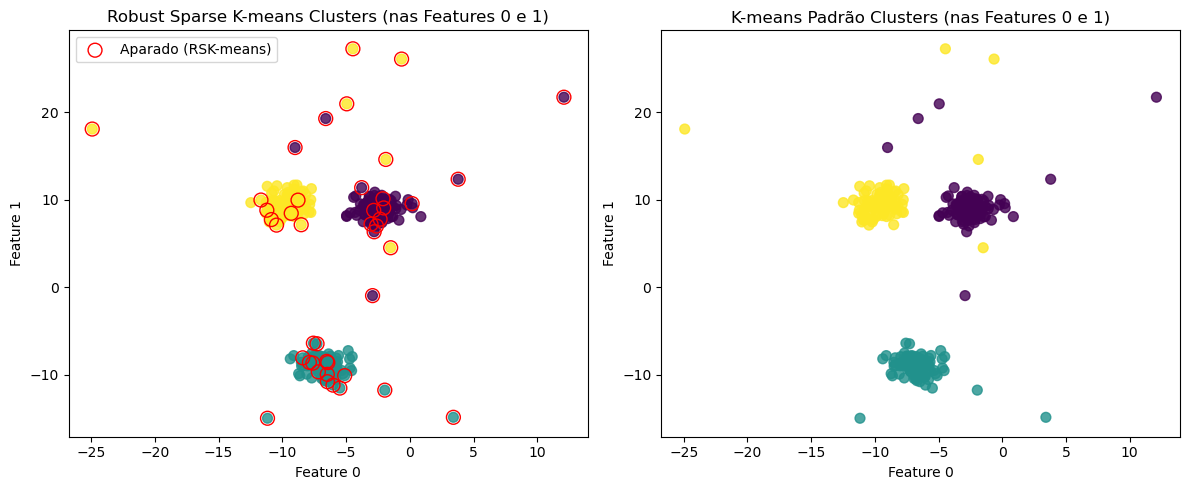

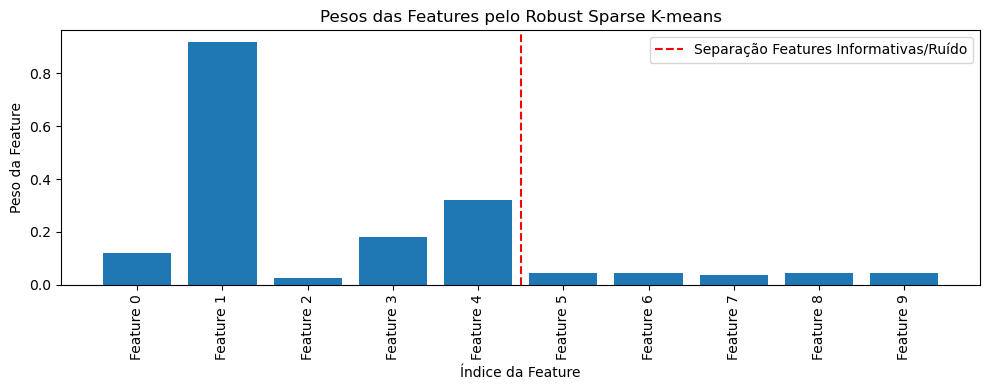

Adjusted Rand Index (RSK-means): 0.9703
Adjusted Rand Index (K-means Padrão): 0.9605


In [7]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Gerar conjunto de dados sintético
n_samples = 300
n_features = 10 # Total de features
n_informative = 5 # Features informativas
n_noise_features = n_features - n_informative
random_state = 42

X_informative, y_true = make_blobs(n_samples=n_samples, centers=3, cluster_std=1.0, random_state=random_state, n_features=n_informative)

# Adicionar features de ruído
X_noise = np.random.randn(n_samples, n_noise_features) * 2 # Ruído com maior variância
X_synthetic = np.hstack((X_informative, X_noise))

# Introduzir outliers
num_outliers = int(0.05 * n_samples) # 5% de outliers
outlier_indices = np.random.choice(n_samples, num_outliers, replace=False)
X_synthetic[outlier_indices, :] += np.random.randn(num_outliers, n_features) * 10 # Adicionar grande ruído aos outliers

X = X_synthetic # Renomear para consistência

# 3.1 Ajustar e Prever com Robust Sparse K-means
# Experimente com diferentes valores de alpha e L1
rskmeans = RobustSparseKMeans(n_clusters=3, alpha=0.1, L1=10, n_init=10, random_state=random_state)
rskmeans.fit(X)
rsk_labels = rskmeans.labels_
rsk_weights = rskmeans.weights_
rsk_trimmed_indices = rskmeans.trimmed_indices_

# 3.2 Ajustar e Prever com K-means padrão para comparação
kmeans = KMeans(n_clusters=3, n_init=10, random_state=random_state)
kmeans.fit(X)
kmeans_labels = kmeans.labels_

# 3.3 Visualização dos Resultados

# Visualização dos clusters nas duas primeiras features informativas
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=rsk_labels, cmap='viridis', s=50, alpha=0.8)
# Destacar pontos aparados
plt.scatter(X[rsk_trimmed_indices, 0], X[rsk_trimmed_indices, 1], facecolors='none', edgecolors='red', s=100, label='Aparado (RSK-means)')
plt.title('Robust Sparse K-means Clusters (nas Features 0 e 1)')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.8)
plt.title('K-means Padrão Clusters (nas Features 0 e 1)')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')

plt.tight_layout()
plt.show()

# Visualização da esparsidade das features (pesos)
plt.figure(figsize=(10, 4))
plt.bar(range(n_features), rsk_weights)
plt.xlabel('Índice da Feature')
plt.ylabel('Peso da Feature')
plt.title('Pesos das Features pelo Robust Sparse K-means')
plt.xticks(range(n_features), [f'Feature {i}' for i in range(n_features)], rotation=90)
plt.axvline(x=n_informative - 0.5, color='red', linestyle='--', label='Separação Features Informativas/Ruído')
plt.legend()
plt.tight_layout()
plt.show()


# 3.4 Comparação de Desempenho
# Usar Adjusted Rand Index (ARI) para comparar as partições com os rótulos verdadeiros

rsk_ari = adjusted_rand_score(y_true, rsk_labels)
kmeans_ari = adjusted_rand_score(y_true, kmeans_labels)

print(f"Adjusted Rand Index (RSK-means): {rsk_ari:.4f}")
print(f"Adjusted Rand Index (K-means Padrão): {kmeans_ari:.4f}")

# Comparar ARI apenas nos pontos NÃO aparados pelo RSK-means (opcional, reflete o foco robusto)
# untouched_indices = np.setdiff1d(np.arange(n_samples), rsk_trimmed_indices)
# if len(untouched_indices) > 0:
#      rsk_ari_untouched = adjusted_rand_score(y_true[untouched_indices], rsk_labels[untouched_indices])
#      print(f"Adjusted Rand Index (RSK-means nos pontos NÃO aparados): {rsk_ari_untouched:.4f}")